In [76]:
import torch
import os
import time
import datetime
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from tqdm.auto import tqdm

import torch
from datasets import load_dataset, ClassLabel, DatasetDict, load_from_disk
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import get_polynomial_decay_schedule_with_warmup
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [77]:
%env WANDB_NOTEBOOK_NAME='muril-nepali-sentiment-analysis.ipynb'
%env WANDB_LOG_MODEL=true
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


env: WANDB_NOTEBOOK_NAME='muril-nepali-sentiment-analysis.ipynb'
env: WANDB_LOG_MODEL=true


True

In [6]:
wandb.init(project="muril-nepali-sentiment-analysis")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [78]:
# load dataset
path = r"/content/drive/MyDrive/nlp-sentiment-analysis.csv"
ds = load_dataset("csv", data_files=path, split='train')

In [79]:
# dataset features (column)
ds.features

{'Title': Value(dtype='string', id=None),
 'Sentiment': Value(dtype='string', id=None)}

In [80]:
# convert label to type ClassLabel
features = ds.features.copy()

# Check if 'Sentiment' is already of type ClassLabel
if not isinstance(features["Sentiment"], ClassLabel):
    features["Sentiment"] = ClassLabel(num_classes=3, names=["negative", "neutral", "positive"])

    def adjust_labels(batch):
        # Convert 'Sentiment' values to their corresponding numerical labels
        batch["Sentiment"] = [features["Sentiment"].str2int(sentiment) for sentiment in batch["Sentiment"]]
        return batch

    ds = ds.map(adjust_labels, batched=True, features=features)

In [81]:
# first ten sentences
ds[:10]

{'Title': ['भूमि व्यवस्था तथा अभिलेख विभागका महानिर्देशकमाथि कार्यकक्षमै दुर्व्यवहार',
  '‘लू’बाट बच्न स्वास्थ्य मन्त्रालयको आग्रह',
  'भैरहवा र पोखराबाट दोहा उडान गर्न कतारी अमिरलाई प्रधानमन्त्रीको आग्रह',
  'विपिन जोशीको रिहाइका लागि पहल गर्न कतारी अमिरलाई प्रधानमन्त्रीको आग्रह',
  'दुई दिने नेपाल भ्रमण सकेर स्वदेश फर्किए कतारका अमिर',
  'नेपालमा लगानीको अध्ययन संयन्त्र बनाउन कतार तयार\xa0',
  'पर्यटन बोर्डको सीइओ नियुक्ति प्रक्रिया अघि नबढाउन उच्च अदालतको अन्तरिम आदेश',
  'नेपाल र कतारबीच २ सम्झौता, ६ समझदारी',
  'आसन्न महाधिवेशन कम्युनिष्ट आन्दोलनको ऐतिहासिक उपलब्धि हो : पूर्वप्रधानमन्त्री खनाल',
  'नेपाल र कतारबीच द्विपक्षीय समझदारीमा हस्ताक्षर'],
 'Sentiment': [0, 1, 1, 1, 1, 2, 1, 2, 2, 2]}

In [82]:
(ds.features['Sentiment'].int2str(0), ds.features['Sentiment'].int2str(1), ds.features['Sentiment'].int2str(2))

('negative', 'neutral', 'positive')

In [83]:
# dimensions
(ds.num_rows, ds.num_columns)

(5000, 2)

In [84]:
train_valid_test = ds.train_test_split(test_size=0.3, stratify_by_column="Sentiment")

In [85]:
# Split the 30% validation
valid_test = train_valid_test['test'].train_test_split(test_size=0.5, stratify_by_column="Sentiment")

In [86]:
ds = DatasetDict({
    'train': train_valid_test['train'],
    'validation': valid_test['train'],
    'test': valid_test['test']
})

In [87]:
ds

DatasetDict({
    train: Dataset({
        features: ['Title', 'Sentiment'],
        num_rows: 3500
    })
    validation: Dataset({
        features: ['Title', 'Sentiment'],
        num_rows: 750
    })
    test: Dataset({
        features: ['Title', 'Sentiment'],
        num_rows: 750
    })
})

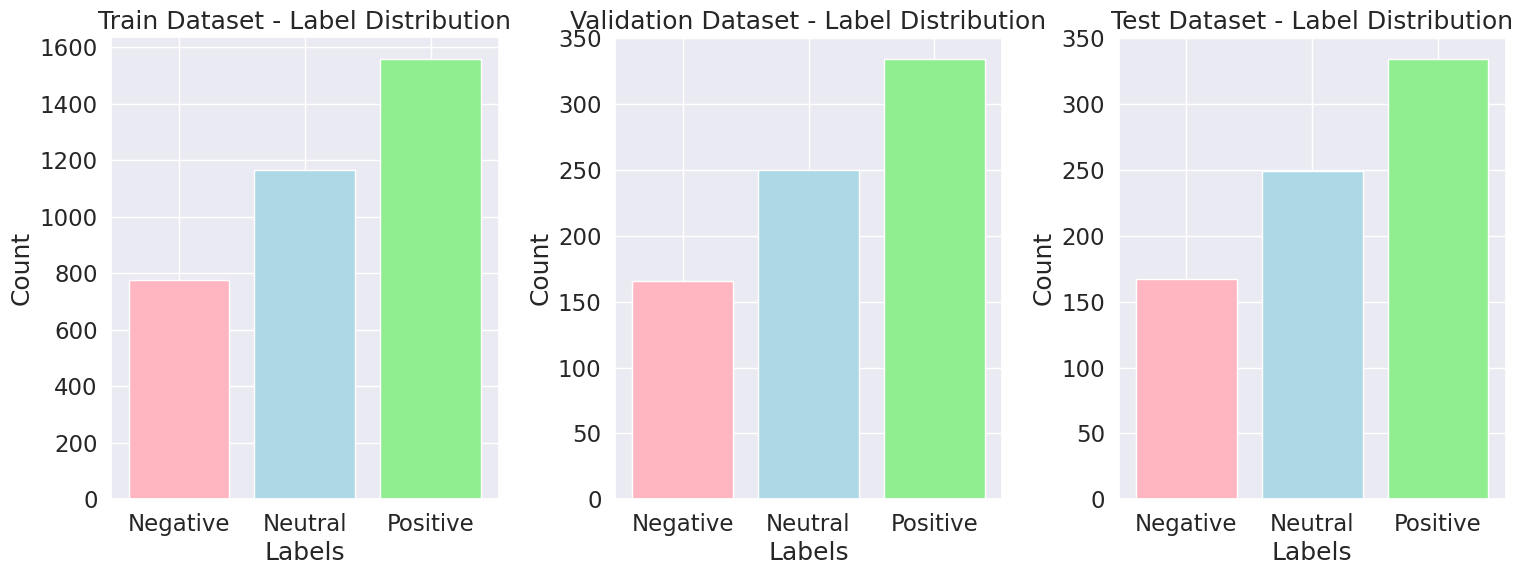

In [109]:
train_data = ds['train']
validation_data = ds['validation']
test_data = ds['test']

# Visualizing data distribution
def plot_label_distribution():
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    for i, (dataset, title) in enumerate(zip([train_data, validation_data, test_data], ['Train', 'Validation', 'Test'])):
        labels = pd.Series(dataset['Sentiment']).value_counts().sort_index()
        axs[i].bar(labels.index, labels.values, color=['#ffb6c1', '#add8e6', '#90ee90'])
        axs[i].set_xlabel('Labels')
        axs[i].set_ylabel('Count')
        axs[i].set_title(f'{title} Dataset - Label Distribution')
        axs[i].set_xticks(labels.index)
        axs[i].set_xticklabels(['Negative', 'Neutral', 'Positive'])
    plt.subplots_adjust(wspace=0.3)
    plt.show()

plot_label_distribution()


In [88]:
ds['train'].features

{'Title': Value(dtype='string', id=None),
 'Sentiment': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [89]:
checkpoint = "google/muril-base-cased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [90]:
id2label= {
    0: "negative",
    1: "neutral",
    2: "postive"
}

label2id = {
    "negative": 0,
    "neutral": 1,
    "postive": 2
}

In [91]:
config = AutoConfig.from_pretrained(checkpoint, label2id=label2id, id2label=id2label, classifier_dropout=0.5)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [92]:
config

BertConfig {
  "_name_or_path": "google/muril-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": 0.5,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "postive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "postive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 197285
}

In [93]:
# test tokenizer
sequence = ds['train']['Title'][:5]
print(sequence)

tokens = tokenizer.tokenize(sequence, is_split_into_words=True)
print(tokens)

tokens = tokenizer(sequence)
print(tokens)

['धावक पार्कीले लन्डन म्याराथनमा प्रतिस्पर्धा गर्ने', '‘सी’ डिभिजन लिग : वाग्मतीमाथि आरसी-३२ को प्रभावशाली जित', 'देशको समृद्धिका निम्ति सबै राजनीतिक शक्ति एकजुट हुनुपर्नेमा सभामुखको जोड', 'मछिन्द्रलाई विराट गोल्डकप', "पोखरा विमानस्थललाई चिनियाँ ऋणको पासो भनेर भ्रम फैलाइरहेका छन्'"]
['धावक', 'पार्क', '##ीले', 'लन्डन', 'म्', '##यार', '##ाथ', '##नमा', 'प्रतिस्पर्धा', 'गर्ने', '‘', 'सी', '’', 'डिभिजन', 'लिग', ':', 'वा', '##ग्', '##मती', '##माथि', 'आर', '##सी', '-', '३२', 'को', 'प्रभावशाली', 'जित', 'देशको', 'समृद्धि', '##का', 'निम्ति', 'सबै', 'राजनीतिक', 'शक्ति', 'एकजुट', 'हुनुपर्ने', '##मा', 'सभामुख', '##को', 'जोड', 'म', '##छिन्', '##द्र', '##लाई', 'विराट', 'गोल्डकप', 'पोखरा', 'विमानस्थल', '##लाई', 'चिनियाँ', 'ऋण', '##को', 'पास', '##ो', 'भनेर', 'भ्रम', 'फैला', '##इरहेका', 'छन्', "'"]
{'input_ids': [[104, 181370, 10476, 25489, 176209, 62436, 55464, 38092, 31299, 21729, 1664, 105], [104, 1049, 2818, 1050, 39905, 12274, 133, 1511, 44896, 24282, 23023, 6130, 4266, 120, 12617, 1125, 23066, 470

In [94]:
def tokenize_function(example):
    return tokenizer(example["Title"], padding=True, truncation=True, return_tensors ="pt")

tokenized_datasets = ds.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['Title'])

#  Rename 'Sentiment' column to 'labels'
tokenized_datasets = tokenized_datasets.rename_column("Sentiment", "labels")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

In [95]:
tokenized_datasets['train'][0]

{'labels': 1,
 'input_ids': [104,
  181370,
  10476,
  25489,
  176209,
  62436,
  55464,
  38092,
  31299,
  21729,
  1664,
  105,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [96]:
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [97]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=16, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], shuffle=True, batch_size=16, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], shuffle=True, batch_size=16, collate_fn=data_collator
)


In [98]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([16]),
 'input_ids': torch.Size([16, 33]),
 'token_type_ids': torch.Size([16, 33]),
 'attention_mask': torch.Size([16, 33])}

In [99]:
outputs = model(**batch.to(device))
print(outputs.loss, outputs.logits.shape)

tensor(1.0962, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([16, 3])


In [100]:
num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=2e-5)
lr_scheduler = get_polynomial_decay_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.1*num_training_steps,
    num_training_steps=num_training_steps,
)

print(num_training_steps)

2190


In [101]:
# Function to calculate the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [102]:
def save_checkpoint(model, epoch_i, output_dir):
    output_path = os.path.join(output_dir, f"checkpoint-{epoch_i}")

    os.makedirs(output_path, exist_ok=True)
    print(f"Saving model checkpoint to {output_path}")

    tokenizer.save_pretrained(output_path)
    model.save_pretrained(output_path, state_dict=model.state_dict())
    print(f"Model saved at: {output_path}")

In [103]:
# Loss tracking for validation
eval_loss_values = []

def validate_model(model, data_loader, desc="Validating"):
    print('Predicting labels for {:,} batches...'.format(len(data_loader)))

    class_names = config.label2id.keys()

    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0

    y_true_list = []
    y_pred_list = []

    for batch in tqdm(data_loader, desc=desc):

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():

            result = model(**batch)

            # Get the loss and "logits" output by the model.
            loss = result.loss
            logits = result.logits
            predictions = torch.argmax(logits, dim=-1)

        # Accumulate the validation loss.
        eval_loss += loss.item()

        y_true_list.extend(batch["labels"])
        y_pred_list.extend(predictions)

    # Compute average validation loss
    average_eval_loss = eval_loss / len(data_loader)

    # Append to loss tracking list
    eval_loss_values.append(average_eval_loss)

    y_true_list = torch.stack(y_true_list).cpu()
    y_pred_list = torch.stack(y_pred_list).cpu()

    report = classification_report(y_true_list, y_pred_list, target_names=class_names, output_dict=True)
    results = {
        'accuracy': report['accuracy'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score'],
    }
    average_eval_loss = eval_loss / len(data_loader)

    return average_eval_loss, results, report, y_true_list, y_pred_list

In [104]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Watch model with WandB
wandb.watch(model, log_freq=100)

# Training parameters
num_epochs = 10
patience = 3  # Stop if no improvement after 3 epochs
best_val_loss = float("inf")
wait = 0  # Counter for patience

# Loss tracking
loss_values = []

# ===== Training =====
for epoch_i in range(num_epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {num_epochs} ========")
    print("Training...")

    # Reset loss and accuracy counters
    train_loss, train_accuracy = 0, 0

    # Put model into training mode
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        batch = {k: v.to(device) for k, v in batch.items()}  # Move to GPU
        optimizer.zero_grad()

        # Forward pass
        result = model(**batch)
        loss = result.loss
        logits = result.logits

        # Accumulate training loss
        train_loss += loss.item()

        # Compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = batch["labels"].to('cpu').numpy()
        train_accuracy += flat_accuracy(logits, label_ids)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        lr_scheduler.step()  # Update learning rate

        # Log batch loss
        if step % 10 == 0 and step != 0:
            wandb.log({"train_batch_loss": loss.item()}, step=step)

    # Compute epoch-level metrics
    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)

    print(f"  Average Training Accuracy: {avg_train_accuracy:.2f}")
    print(f"  Average Training Loss: {avg_train_loss:.4f}")

    wandb.log({
        "epoch": epoch_i,
        "avg_train_loss": avg_train_loss,
        "avg_train_accuracy": avg_train_accuracy,
    })

    loss_values.append(avg_train_loss)

    # Save model checkpoint
    save_checkpoint(model, epoch_i, "./checkpoints/")

    # ============== Validation ===========

    print("\nRunning Validation...")
    eval_loss, results, report, _, _ = validate_model(model, test_dataloader, desc="Validating")

    print("  Average Validation Loss: {0:.2f}".format(eval_loss))
    for key, value in results.items():
        print("  {}: {:.2f}".format(key,value))

    wandb.log({'avg_eval_loss':eval_loss})
    wandb.log(results)

    # Early stopping logic
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
        print("  ** Best model saved! **")
    else:
        wait += 1
        if wait >= patience:
            print("\n  ** Early stopping triggered! **")
            break

print("\nTraining complete!")



======== Epoch 1 / 10 ========
Training...


Training:   0%|          | 0/219 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 10 that is less than the current step 264. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 264. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 264. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 264. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 264. Steps must be monotonically increasing, so this data will be ignored. See https:/

  Average Training Accuracy: 0.45
  Average Training Loss: 1.0720
Saving model checkpoint to ./checkpoints/checkpoint-0


wandb: WARNING Tried to log to step 210 that is less than the current step 264. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Model saved at: ./checkpoints/checkpoint-0

Running Validation...
Predicting labels for 47 batches...


Validating:   0%|          | 0/47 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Average Validation Loss: 1.00
  accuracy: 0.56
  precision: 0.41
  recall: 0.56
  f1-score: 0.44
  ** Best model saved! **

======== Epoch 2 / 10 ========
Training...


Training:   0%|          | 0/219 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 10 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See https:/

  Average Training Accuracy: 0.60
  Average Training Loss: 0.8976
Saving model checkpoint to ./checkpoints/checkpoint-1


wandb: WARNING Tried to log to step 170 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 180 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 190 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 200 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 210 that is less than the current step 267. Steps must be monotonically increasing, so this data will be ignored. See ht

Model saved at: ./checkpoints/checkpoint-1

Running Validation...
Predicting labels for 47 batches...


Validating:   0%|          | 0/47 [00:00<?, ?it/s]

  Average Validation Loss: 0.81
  accuracy: 0.63
  precision: 0.60
  recall: 0.63
  f1-score: 0.55
  ** Best model saved! **

======== Epoch 3 / 10 ========
Training...


Training:   0%|          | 0/219 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 10 that is less than the current step 270. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 270. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 270. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 270. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 270. Steps must be monotonically increasing, so this data will be ignored. See https:/

  Average Training Accuracy: 0.69
  Average Training Loss: 0.7565
Saving model checkpoint to ./checkpoints/checkpoint-2
Model saved at: ./checkpoints/checkpoint-2

Running Validation...
Predicting labels for 47 batches...


Validating:   0%|          | 0/47 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 210 that is less than the current step 270. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


  Average Validation Loss: 0.74
  accuracy: 0.69
  precision: 0.68
  recall: 0.69
  f1-score: 0.68
  ** Best model saved! **

======== Epoch 4 / 10 ========
Training...


Training:   0%|          | 0/219 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 10 that is less than the current step 273. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 273. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 273. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 273. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 273. Steps must be monotonically increasing, so this data will be ignored. See https:/

  Average Training Accuracy: 0.78
  Average Training Loss: 0.6432
Saving model checkpoint to ./checkpoints/checkpoint-3


wandb: WARNING Tried to log to step 190 that is less than the current step 273. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 200 that is less than the current step 273. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 210 that is less than the current step 273. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Model saved at: ./checkpoints/checkpoint-3

Running Validation...
Predicting labels for 47 batches...


Validating:   0%|          | 0/47 [00:00<?, ?it/s]

  Average Validation Loss: 0.68
  accuracy: 0.73
  precision: 0.72
  recall: 0.73
  f1-score: 0.72
  ** Best model saved! **

======== Epoch 5 / 10 ========
Training...


Training:   0%|          | 0/219 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 10 that is less than the current step 276. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 276. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 276. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 276. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 276. Steps must be monotonically increasing, so this data will be ignored. See https:/

  Average Training Accuracy: 0.83
  Average Training Loss: 0.5425
Saving model checkpoint to ./checkpoints/checkpoint-4


wandb: WARNING Tried to log to step 190 that is less than the current step 276. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 200 that is less than the current step 276. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 210 that is less than the current step 276. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Model saved at: ./checkpoints/checkpoint-4

Running Validation...
Predicting labels for 47 batches...


Validating:   0%|          | 0/47 [00:00<?, ?it/s]

  Average Validation Loss: 0.66
  accuracy: 0.75
  precision: 0.75
  recall: 0.75
  f1-score: 0.75
  ** Best model saved! **

======== Epoch 6 / 10 ========
Training...


Training:   0%|          | 0/219 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 10 that is less than the current step 279. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 279. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 279. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 279. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 279. Steps must be monotonically increasing, so this data will be ignored. See https:/

  Average Training Accuracy: 0.86
  Average Training Loss: 0.4683
Saving model checkpoint to ./checkpoints/checkpoint-5


wandb: WARNING Tried to log to step 190 that is less than the current step 279. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 200 that is less than the current step 279. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 210 that is less than the current step 279. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Model saved at: ./checkpoints/checkpoint-5

Running Validation...
Predicting labels for 47 batches...


Validating:   0%|          | 0/47 [00:00<?, ?it/s]

  Average Validation Loss: 0.67
  accuracy: 0.75
  precision: 0.75
  recall: 0.75
  f1-score: 0.75

======== Epoch 7 / 10 ========
Training...


Training:   0%|          | 0/219 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 10 that is less than the current step 282. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 282. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 282. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 282. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 282. Steps must be monotonically increasing, so this data will be ignored. See https:/

  Average Training Accuracy: 0.89
  Average Training Loss: 0.3968
Saving model checkpoint to ./checkpoints/checkpoint-6
Model saved at: ./checkpoints/checkpoint-6

Running Validation...
Predicting labels for 47 batches...


Validating:   0%|          | 0/47 [00:00<?, ?it/s]

  Average Validation Loss: 0.68
  accuracy: 0.75
  precision: 0.75
  recall: 0.75
  f1-score: 0.75

======== Epoch 8 / 10 ========
Training...


Training:   0%|          | 0/219 [00:00<?, ?it/s]

wandb: WARNING Tried to log to step 10 that is less than the current step 285. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 285. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 30 that is less than the current step 285. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 285. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 50 that is less than the current step 285. Steps must be monotonically increasing, so this data will be ignored. See https:/

  Average Training Accuracy: 0.90
  Average Training Loss: 0.3643
Saving model checkpoint to ./checkpoints/checkpoint-7


wandb: WARNING Tried to log to step 180 that is less than the current step 285. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 190 that is less than the current step 285. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Model saved at: ./checkpoints/checkpoint-7

Running Validation...
Predicting labels for 47 batches...


wandb: WARNING Tried to log to step 200 that is less than the current step 285. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 210 that is less than the current step 285. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


Validating:   0%|          | 0/47 [00:00<?, ?it/s]

  Average Validation Loss: 0.70
  accuracy: 0.74
  precision: 0.74
  recall: 0.74
  f1-score: 0.74

  ** Early stopping triggered! **

Training complete!


In [110]:
logits = result.logits.detach().cpu().numpy()
print("Logits:", logits[:5])  # Check first 5 predictions


Logits: [[-1.147378    1.6692015  -0.25526804]
 [-2.0405421  -0.14941262  1.9757633 ]
 [ 1.7705028  -0.34854758 -1.5547856 ]
 [-0.6381108   1.573216   -0.81396866]
 [-2.0068624  -0.28572854  2.2182825 ]]


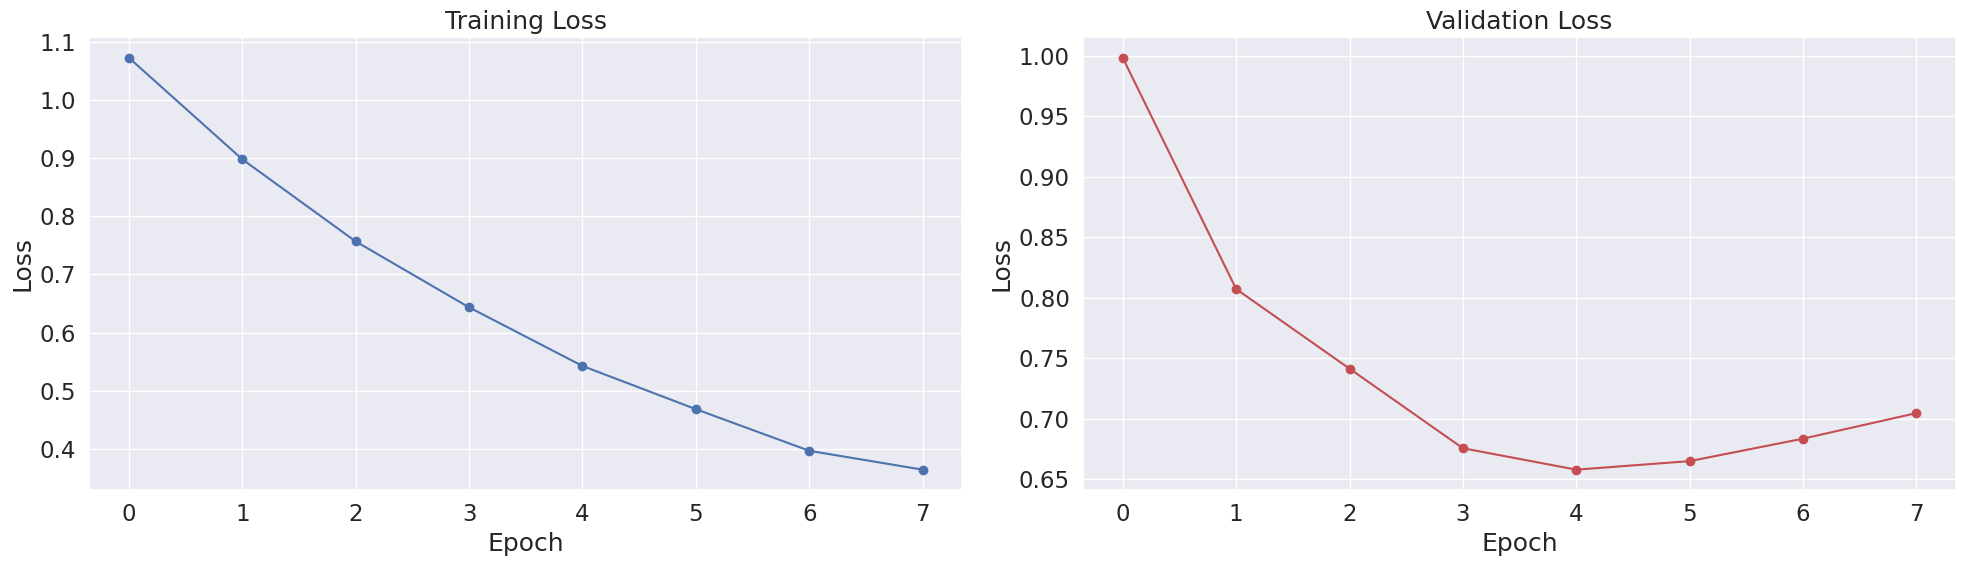

In [111]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot training loss on the first subplot (axes[0])
axes[0].plot(loss_values, 'b-o')
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

# Plot validation loss on the second subplot (axes[1])
axes[1].plot(eval_loss_values, 'r-o')
axes[1].set_title("Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [112]:
checkpoint = './checkpoints/checkpoint-4/'

In [115]:
id2label= {
    0: "negative",
    1: "neutral",
    2: "postive"
}

label2id = {
    "negative": 0,
    "neutral": 1,
    "postive": 2
}

In [116]:
config = AutoConfig.from_pretrained(checkpoint, label2id=label2id, id2label=id2label)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [117]:
eval_loss, results, report, y_true_list, y_pred_list = validate_model(model, test_dataloader, desc="Testing")

print("  Average Validation Loss: {0:.2f}".format(eval_loss))
for key, value in results.items():
    print("  {}: {:.2f}".format(key,value))

Predicting labels for 47 batches...


Testing:   0%|          | 0/47 [00:00<?, ?it/s]

  Average Validation Loss: 0.66
  accuracy: 0.75
  precision: 0.75
  recall: 0.75
  f1-score: 0.75


In [118]:
pprint(report)

{'accuracy': 0.7493333333333333,
 'macro avg': {'f1-score': 0.7487348701526932,
               'precision': 0.7479942173045627,
               'recall': 0.7523587363425759,
               'support': 750.0},
 'negative': {'f1-score': 0.8173913043478261,
              'precision': 0.7921348314606742,
              'recall': 0.844311377245509,
              'support': 167.0},
 'neutral': {'f1-score': 0.6381156316916489,
             'precision': 0.6834862385321101,
             'recall': 0.5983935742971888,
             'support': 249.0},
 'postive': {'f1-score': 0.7906976744186046,
             'precision': 0.768361581920904,
             'recall': 0.8143712574850299,
             'support': 334.0},
 'weighted avg': {'f1-score': 0.7459842178308286,
                  'precision': 0.7454764781466798,
                  'recall': 0.7493333333333333,
                  'support': 750.0}}


In [119]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.rcParams["figure.figsize"] = (10,5)
  plt.ylabel('True Sentiment')
  plt.xlabel('Predicted Sentiment');

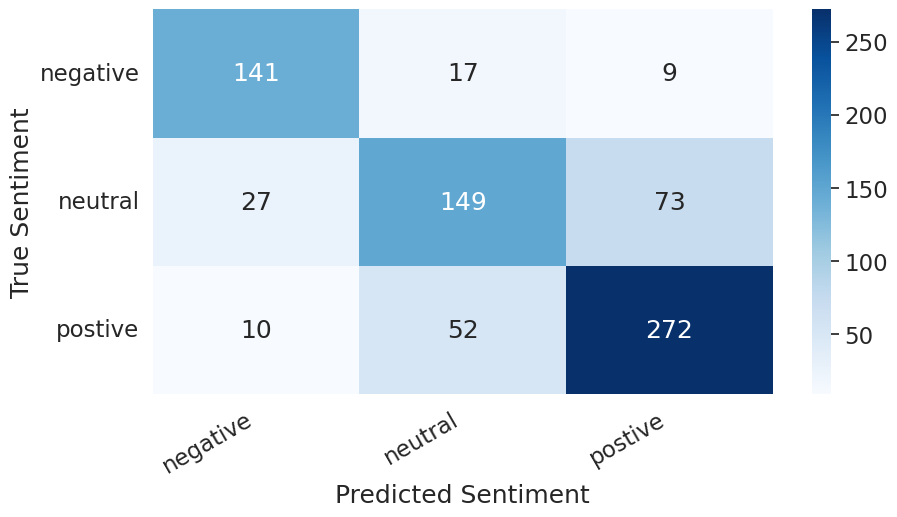

In [120]:
class_names = config.label2id.keys()
cm = confusion_matrix(y_true_list, y_pred_list)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [121]:
print(classification_report(y_true_list, y_pred_list, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.79      0.84      0.82       167
     neutral       0.68      0.60      0.64       249
     postive       0.77      0.81      0.79       334

    accuracy                           0.75       750
   macro avg       0.75      0.75      0.75       750
weighted avg       0.75      0.75      0.75       750



In [122]:
saved_checkpoint = checkpoint

config = AutoConfig.from_pretrained(saved_checkpoint, label2id=label2id, id2label=id2label)
tokenizer = AutoTokenizer.from_pretrained(saved_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(saved_checkpoint, num_labels=3)

In [123]:
sequences = ['नेपालमा लगानीको अध्ययन संयन्त्र बनाउन कतार तयार ','भूमि व्यवस्था तथा अभिलेख विभागका महानिर्देशकमाथि कार्यकक्षमै दुर्व्यवहार','कांग्रेस संसदीय दलको बैठक बस्दै']

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.6300, -0.1505,  1.6800],
        [ 1.4994, -0.4258, -1.0785],
        [-0.7320,  0.9803, -0.1959]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [124]:
predictions = torch.nn.functional.softmax(output.logits, dim=-1)
print(predictions)

tensor([[0.0305, 0.1340, 0.8355],
        [0.8185, 0.1194, 0.0621],
        [0.1212, 0.6716, 0.2072]], grad_fn=<SoftmaxBackward0>)


In [127]:
import torch.nn.functional as F
def get_prediction(sentence, tokenize=tokenizer, model=model):
    tokens = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    # Ensure model and tokens are on the same device
    model = model.to(device)
    tokens = {name: tensor.to(device) for name, tensor in tokens.items()}

    # Get prediction
    with torch.no_grad():
        logits = model(**tokens)[0].to(device) # Output logits

    # Convert logits to probabilities using softmax
    probabilities = F.softmax(logits, dim=1).cpu().numpy()  # Move probabilities back to CPU for NumPy

    # Get the top prediction class and its associated probability
    top_prediction_idx = probabilities.argmax(axis=1)[0]
    confidence_score = probabilities[0][top_prediction_idx]  # Confidence score for top class

    # Map the top prediction index to the corresponding label
    label = config.id2label[top_prediction_idx] if top_prediction_idx in [0, 1, 2] else 'no prediction'

    return label, confidence_score


In [128]:
get_prediction('नेपालमा लगानीको अध्ययन संयन्त्र बनाउन कतार तयार ')


('postive', 0.8355256)

In [129]:
get_prediction('भूमि व्यवस्था तथा अभिलेख विभागका महानिर्देशकमाथि कार्यकक्षमै दुर्व्यवहार')

('negative', 0.8184822)

In [130]:
get_prediction('कांग्रेस संसदीय दलको बैठक बस्दै')

('neutral', 0.6716368)